# Project Title
### Data Engineering Capstone Project

#### Project Summary

This project aims to develop a data pipeline for the creation of an analysis database with data on COVID 19 in Brazil.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
!pip install pandas-profiling[notebook]
import pandas as pd
import re
from pandas_profiling import ProfileReport
from IPython import display

    100% |████████████████████████████████| 235kB 7.4MB/s ta 0:00:01
  Found existing installation: python-dateutil 2.6.1
    Uninstalling python-dateutil-2.6.1:
      Successfully uninstalled python-dateutil-2.6.1


### Step 1: Scope the Project and Gather Data

#### Scope 

In this project, the Coronavirus - Brazil dataset will be used as a data source (https://www.kaggle.com/unanimad/corona-virus-brazil). This dataset has information on the number of cases in Brazil. The data is available from Jan/30/2020, when the first suspect case appeared in Brazil.


#### Describe and Gather Data 

In this dataset there are 6 data sources, but only the following databases will be used:
- **brazil_cities_coordinates**: Geographic coordinates data of the city.
- **brazil_covid19_cities**: Cases of COVID by city per day.
- **brazil_population_2019**: Population size by city. In this file, we also have the health region, which is a region in which the city is a part of the care of COVID, hospital centers, restrictions laws, etc.

As for the solution, it is planned to create a Data Warehouse within Redshift. The schema used will be the star schema. As for automation, the process can be easily adapted to Airflow.

### Step 2: Explore and Assess the Data
#### Explore the Data & Cleaning Steps

To start an analysis, before importing by pandas, a problem was verified in one of the fields in the *brazil_population_2019* file. The 'health_region' field of the city, because it has a comma (which is the default separator of the file), was making it impossible to import the file. For this, the following data adjustment process was performed, generating the file *brazil_population_2019_clean*.

In [2]:
# Performing cleaning tasks here
file = 'data/brazil_population_2019.csv'

# open your csv and read as a text string
with open(file, 'r') as f:
    file_text = f.read()

find_str = 'Manaus, Entorno e Alto Rio Negro'
replace_str = 'Manaus Entorno e Alto Rio Negro'

# substitute
new_csv_str = re.sub(find_str, replace_str, file_text)

# open new file and save
new_csv_path = 'data/brazil_population_2019_clean.csv' # or whatever path and name you want
with open(new_csv_path, 'w') as f:
    f.write(new_csv_str)

##### brazil_cities_coordinates file


In [3]:
# Read in the data here
df_brazil_cities_coordinates = pd.read_csv('data/brazil_cities_coordinates.csv')
profile_brazil_cities_coordinates = ProfileReport(df_brazil_cities_coordinates, title='brazil_cities_coordinates', minimal=True)#, explorative=True)
profile_brazil_cities_coordinates.to_notebook_iframe()

Summarize dataset:   0%|          | 0/14 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Important Results (brazil_cities_coordinates):**
- Missing cells: 0
- Duplicate rows: 0
- City Code: 100.0% distinct values (Prymary key)
____________________________________________________________

#### brazil_population_2019 file

In [4]:
df_brazil_population_2019 = pd.read_csv('data/brazil_population_2019_clean.csv')
profile_df_brazil_population_2019 = ProfileReport(df_brazil_population_2019, title='df_brazil_population_2019', minimal=True)#, explorative=True)
profile_df_brazil_population_2019.to_notebook_iframe()

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Important Results (brazil_population_2019):**
- Missing cells: 0
- Duplicate rows: 0
- City Code: 100.0% distinct values (Prymary key)
____________________________________________________________

#### brazil_covid19_cities file

In [5]:
df_brazil_covid19_cities = pd.read_csv('data/brazil_covid19_cities.csv')
profile_df_brazil_covid19_cities = ProfileReport(df_brazil_covid19_cities, title='df_brazil_covid19_cities', minimal=True)#, explorative=True)
profile_df_brazil_covid19_cities.to_notebook_iframe()

Summarize dataset:   0%|          | 0/14 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Important Results (brazil_covid19_cities):**
- Missing cells: 0
- Duplicate rows: 0
____________________________________________________________

**One City - Casos Acumulados**

<AxesSubplot:xlabel='date'>

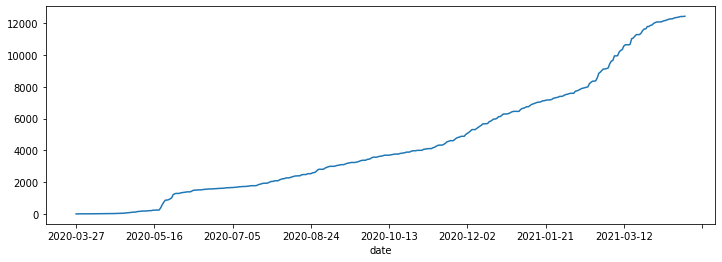

In [6]:
df_cities_lajeado = df_brazil_covid19_cities[(df_brazil_covid19_cities['name']=='Lajeado')&(df_brazil_covid19_cities['name']=='Lajeado')&(df_brazil_covid19_cities['state']=='RS')]
df_cities_lajeado.set_index('date', inplace=True)
df_cities_lajeado['cases'].plot(figsize=(12, 4))

**One City - Novos Casos**

<AxesSubplot:xlabel='date'>

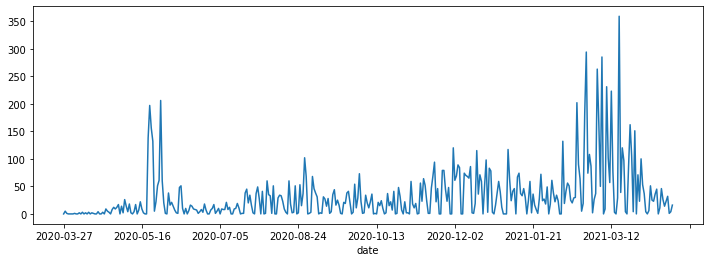

In [13]:
df_cities_lajeado['new'] = df_cities_lajeado['cases'] - df_cities_lajeado['cases'].shift(fill_value=0)
df_cities_lajeado['new'] = df_cities_lajeado['new'].clip(lower=0)
df_cities_lajeado['new'].plot(figsize=(12, 4))

In [14]:
df_cities_lajeado.head()

,state,name,code,cases,deaths,new
date,,,,,,
2020-03-27,RS,Lajeado,431140.0,0,0,0
2020-03-28,RS,Lajeado,431140.0,5,0,5
2020-03-29,RS,Lajeado,431140.0,6,0,1
2020-03-30,RS,Lajeado,431140.0,5,0,0
2020-03-31,RS,Lajeado,431140.0,5,0,0


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

As shown in the image below, I am using a star schema to keep the data organized, to facilitate joins, filters, and aggregations. I have the tables *time, health_region, cities, region* as dimensions and the table *coronavirus* as fact.

According to this definition, seeking to optimize the evaluations by health_region, the tables will have the following characteristics:
- **time**: Distribution style was defined as ALL and the field date_id was used as sortkey.
- **health**_region: Distribution style was defined as ALL and the field health_region_id was used as sortkey.
- **cities**: Distribution style was defined as ALL and the field city_id was used as sortkey.
- **region**: Distribution style was defined as ALL and the field state_id was used as sortkey.
- **coronavirus**: has the health_region_id field as a distkey. It has the following compound sortkey state_id, region_id and city_id.

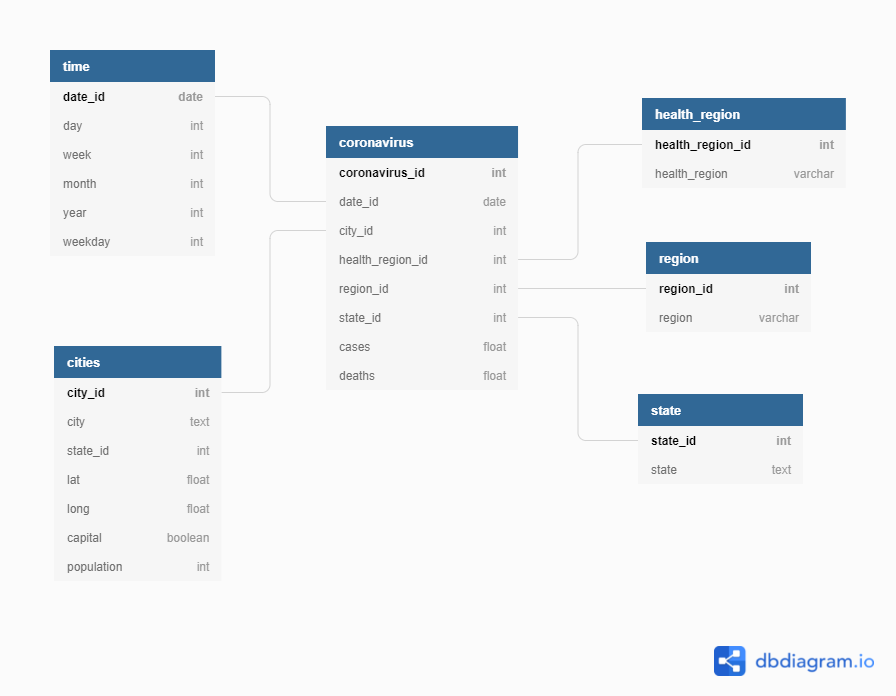

In [2]:
from IPython import display
display.Image("Coronavirus-Brazil.png")

#### 3.2 Mapping Out Data Pipelines

- As previously described, to start the process, it is necessary to correct the problem in the health_region field of the file brazil_population_2019 
- Create the Redshift cluster
- Configure the S3 path of the files and the data to access the Redshift in the `dwh.cfg` file
- `create_tables.py`: Create the **staging** tables *(staging_brazil_cities_coordinates, staging_brazil_population_2019, staging_brazil_covid19_cities)*, **dimensions** *(cities, health_region, region, state, time)* and **fact** *(coronavirus)* on Redshift.
- Copy data from S3 to Redshift
- `Etl.py`: Insert the data in the dimension and fact tables from the staging tables.

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model

**Create Tables**

In [47]:
!python3 create_tables.py

**Copy and Insert data**

In [48]:
!python3 etl.py

Run copy_table_queries
copy_table_queries OK
Run insert_table_queries
insert_table_queries OK
Run fact_insert
fact_insert OK


#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
   - **All dimension tables have primary keys**
    - **The types of fields have been defined according to the need for use and are compatible if they exist in more than one table.**
 * Unit tests for the scripts to ensure they are doing the right thing
   - **Processos foram criados com logs de execução para acompnhamento**
 * Source/Count checks to ensure completeness

**Unique cities:** 
  - **Query:** select count(`*`) from cities 
  Result: **5700**
  - **Query Validation:** Select count(distinct city_id) from cities
  Result: **5570**

**Unique region:** 
  - **Query:** select count(`*`) from region 
  Result: **5**
  - **Query Validation:** Select count(distinct region_id) from region
  Result: **5**
  
**Unique state:** 
  - **Query:** select count(`*`) from state 
  Result: **27**
  - **Query Validation:** Select count(distinct state_id) from state
  Result: **27**


**Count Fact - coronavirus:** 
  - **Query:** select count(`*`) from staging_brazil_covid19_cities 
  Result: **2172300**
  - **Query Validation:** Select count(`*`) from coronavirus
  Result: **2172300**
 


#### 4.3 Data dictionary 

**Cities Table:**

**city_id:** Unique City Code <br>
**city:** Name of the city<br>
**state_id:** State code. Regarding the `state` table .<br>
**lat:** City latitude<br>
**long:** Longitude of the city<br>
**capital:** Indicates that the city is the state capital.<br>
**population:** Indicates the population of the city, when available.<br>


**Health Region Table:** A conglomerate of cities that bring together a COVID attend center. In other words, if the city of Lajeado and Estrela are part of the same Health Region (29 - Vales e Montanhas), the number of cases will be measured by adding the value of the two (or more) cities.

**health_region_id:** Unique health region code<br>
**health_region:** Health region name<br>


**Region Table:** Geographic region

**region_id:** Unique Region Code<br>
**region:** Region name<br>


**State Table:**

**state_id:** Unique state code<br>
**State:** State Name<br>


**Time Table:** 

**date_id:** Date and unique identification of the time dimension.<br>
**day:** Day referring to the date in question<br>
**week:** Week referring to the date in question<br>
**month:** Month referring to the date in question<br>
**year:** Year referring to the date in question<br>
**weekday:** Day of the week for the date in question<br>


**Coronavirus Fact Table:** The table gathers case data by city, region, state, health region, and date.

**coronavirus_id:** Unique record identifier<br>
**date_id:** Date and unique identification of the time dimension. (time dimension)<br>
**city_id:** City identifier (cities dimension)<br>
**health_region_id:** Health region identifier (health_region dimension)<br>
**region_id:** Region identifier (region dimension)<br>
**state_id:** State dimension identifier<br>
**cases:** Number of cases<br>
**deaths:** Number of Deaths<br>


#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
**The S3 data service is widely used for storing datasets. In conjunction with Redshift, it becomes a great choice for processing large files and providing analytics services. In addition, with the horizontal scaling of resources that Redshift provides, it is possible to meet great demands and at the same time reduce resources if they are not being used, generating savings. As the chosen schema style was the star schema, I needed a relational database for this type of project.**

* Propose how often the data should be updated and why.
**For the use in question, the update can be daily, as the data is released daily and it does not make sense to update it more frequently.**


* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 **I would probably load the data with a monthly break. Another evaluation that would have to be done is on the diststyle, sortkey and distkey, to understand if there would be another optimized form of configuration.**
 
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 **A job could be easily configured for loading via Airflow to update the data and the panel could directly consult this data.**
 
 * The database needed to be accessed by 100+ people.
 **I don't see any major changes in this case. The connection could easily be made available through tools like Tableau, Power BI, or Qlikview.**